In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import collections

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve

from sklearn.model_selection import train_test_split

def dictionarize(data):
    valors_unics = data.unique()
    return { j: i + 1 for i, j in enumerate(valors_unics) }

## Introducció a la base de dades

In [2]:
train = pd.read_csv('train.csv')
train.shape

(43957, 15)

In [3]:
train.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [4]:
train.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_>50K
count,43957.000000,4.395700e+04,43957.000000,43957.000000,43957.000000,43957.000000,43957.000000
mean,38.617149,1.896730e+05,10.074118,1093.559797,88.246491,40.407694,0.239279
std,13.734401,1.058215e+05,2.575092,7570.536063,404.588410,12.400303,0.426648
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.174960e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781000e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376710e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


## Data Mining

In [5]:
train_m = train.copy()
train_m.isnull().sum()

age                   0
workclass          2498
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      763
income_>50K           0
dtype: int64

In [6]:
train_m.dropna(inplace = True)

In [7]:
print(train.shape)
print(train_m.shape)

(43957, 15)
(40727, 15)


In [8]:
train_m.rename(columns = {'income_>50K':'target'}, inplace = True)

categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                       'race', 'gender', 'native-country']
categorical_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country']

In [9]:
train_m.drop(columns = {'educational-num'}, inplace = True)

Private             30057
Self-emp-not-inc     3404
Local-gov            2792
State-gov            1721
Self-emp-inc         1471
Federal-gov          1262
Without-pay            20
Name: workclass, dtype: int64


<AxesSubplot:xlabel='count', ylabel='workclass'>

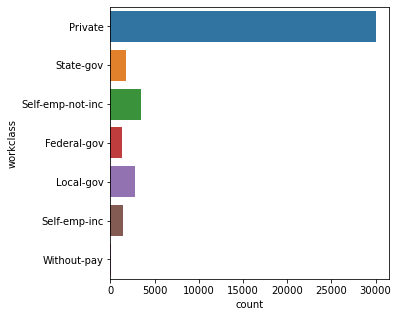

In [10]:
print(train_m['workclass'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "workclass")

Private       30057
Government     5775
Self-emp       4875
Name: workclass, dtype: int64


<AxesSubplot:xlabel='count', ylabel='workclass'>

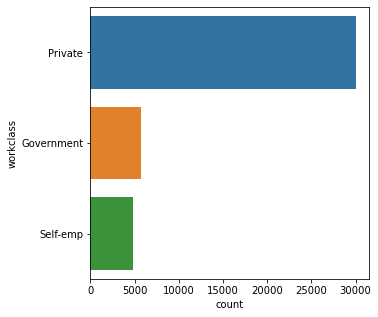

In [11]:
train_m.drop(train_m[train_m.workclass == 'Without-pay'].index, inplace = True)

train_m['workclass'].replace(['Self-emp-not-inc', 'Self-emp-inc'], 'Self-emp', inplace = True)
train_m['workclass'].replace(['Local-gov', 'State-gov', 'Federal-gov'], 'Government', inplace = True)

print(train_m['workclass'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "workclass")

HS-grad         13298
Some-college     8905
Bachelors        6811
Masters          2267
Assoc-voc        1740
11th             1481
Assoc-acdm       1358
10th             1098
7th-8th           738
Prof-school       706
9th               615
12th              520
Doctorate         489
5th-6th           413
1st-4th           202
Preschool          66
Name: education, dtype: int64


<AxesSubplot:xlabel='count', ylabel='education'>

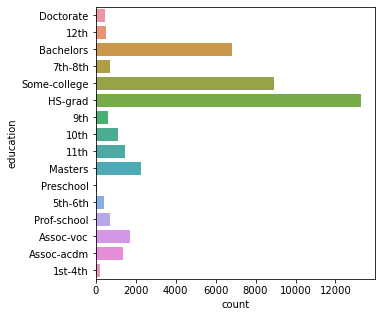

In [12]:
print(train_m['education'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "education")

College              32112
High-School           3714
Postgraduate          3462
Middle-School          738
Elementary-School      681
Name: education, dtype: int64


<AxesSubplot:xlabel='count', ylabel='education'>

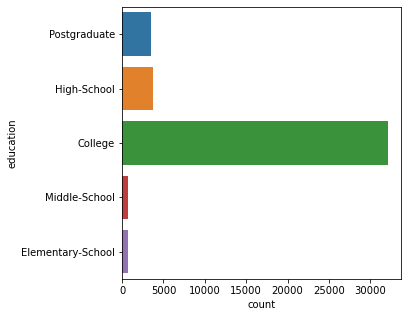

In [13]:
train_m['education'].replace(['Preschool', '1st-4th', '5th-6th'], 'Elementary-School', inplace = True)
train_m['education'].replace(['7th-8th'], 'Middle-School', inplace = True)
train_m['education'].replace(['9th', '10th', '11th', '12th'], 'High-School', inplace = True)
train_m['education'].replace(['HS-grad', 'Bachelors', 'Some-college', 'Assoc-voc', 'Assoc-acdm'], 'College', inplace = True)
train_m['education'].replace(['Prof-school', 'Masters', 'Doctorate',], 'Postgraduate', inplace = True)

print(train_m['education'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "education")

Married-civ-spouse       18964
Never-married            13150
Divorced                  5666
Separated                 1252
Widowed                   1150
Married-spouse-absent      499
Married-AF-spouse           26
Name: marital-status, dtype: int64


<AxesSubplot:xlabel='count', ylabel='marital-status'>

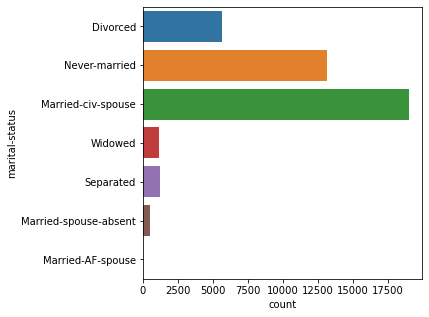

In [14]:
print(train_m['marital-status'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "marital-status")

Married          19489
Never-married    13150
Divorced          5666
Separated         1252
Widowed           1150
Name: marital-status, dtype: int64


<AxesSubplot:xlabel='count', ylabel='marital-status'>

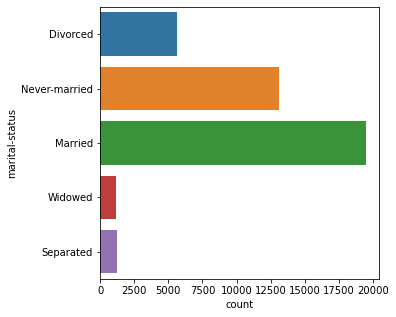

In [15]:
train_m['marital-status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 
                                   'Married-AF-spouse'], 'Married', inplace = True)

print(train_m['marital-status'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "marital-status")

Craft-repair         5432
Exec-managerial      5414
Prof-specialty       5380
Adm-clerical         4941
Sales                4876
Other-service        4347
Machine-op-inspct    2661
Transport-moving     2084
Handlers-cleaners    1852
Farming-fishing      1330
Tech-support         1296
Protective-serv       867
Priv-house-serv       215
Armed-Forces           12
Name: occupation, dtype: int64


<AxesSubplot:xlabel='count', ylabel='occupation'>

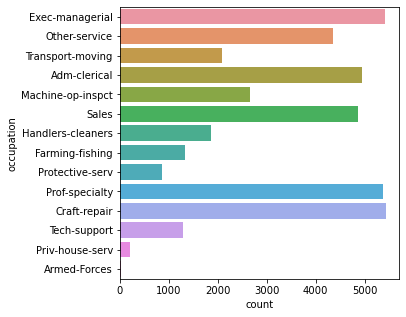

In [16]:
print(train_m['occupation'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "occupation")

Husband           16808
Not-in-family     10528
Own-child          5970
Unmarried          4301
Wife               1881
Other-relative     1219
Name: relationship, dtype: int64


<AxesSubplot:xlabel='count', ylabel='relationship'>

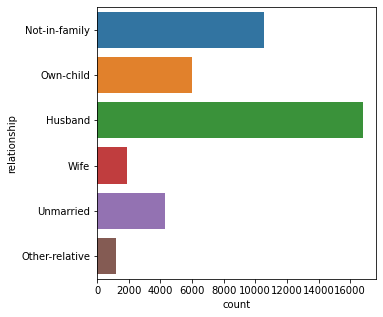

In [17]:
print(train_m['relationship'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "relationship")

Married           18689
Not-in-family     10528
Own-child          5970
Unmarried          4301
Other-relative     1219
Name: relationship, dtype: int64


<AxesSubplot:xlabel='count', ylabel='relationship'>

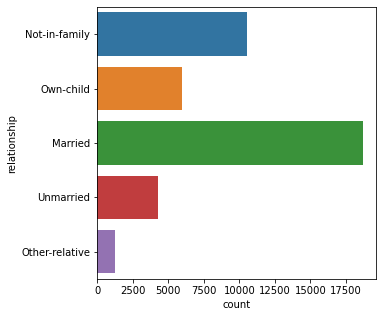

In [18]:
train_m['relationship'].replace(['Husband', 'Wife'], 'Married', inplace = True)

print(train_m['relationship'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "relationship")

White                 85.953276
Black                  9.374309
Asian-Pac-Islander     2.906134
Amer-Indian-Eskimo     0.967893
Other                  0.798388
Name: race, dtype: float64


<AxesSubplot:xlabel='count', ylabel='race'>

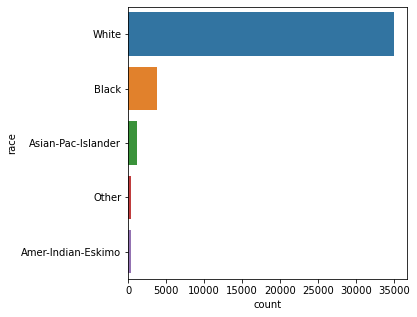

In [19]:
print(train_m['race'].value_counts(normalize = True) * 100)

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "race")

Male      27477
Female    13230
Name: gender, dtype: int64


<AxesSubplot:xlabel='count', ylabel='gender'>

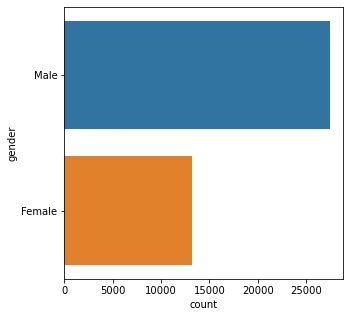

In [20]:
print(train_m['gender'].value_counts())

plt.figure(figsize=(5,5))
sns.countplot(data = train_m, y = "gender")

United-States                 91.259489
Mexico                         2.058614
Philippines                    0.638711
Germany                        0.432358
Puerto-Rico                    0.390596
Canada                         0.341465
El-Salvador                    0.336551
India                          0.319355
Cuba                           0.294790
China                          0.260397
England                        0.250571
Jamaica                        0.230919
South                          0.223549
Dominican-Republic             0.223549
Italy                          0.218636
Japan                          0.198983
Guatemala                      0.189157
Vietnam                        0.184243
Columbia                       0.176874
Poland                         0.162134
Haiti                          0.159678
Portugal                       0.135112
Iran                           0.122829
Taiwan                         0.120372
Nicaragua                      0.110546


<AxesSubplot:xlabel='count', ylabel='native-country'>

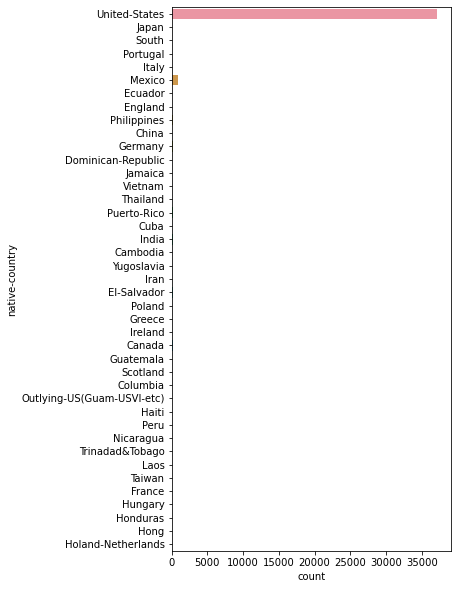

In [21]:
print(train_m['native-country'].value_counts(normalize = True) * 100)

plt.figure(figsize=(5,10))
sns.countplot(data = train_m, y = "native-country")

In [22]:
print(train.shape)
print(train_m.shape)

(43957, 15)
(40707, 14)


In [23]:
for x in categorical_columns:
    diccionari = dictionarize(train_m[x])
    train_m[x] = [diccionari[i] for i in train_m[x]]

In [24]:
train_m.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,target
0,67,1,366425,1,1,1,1,1,1,99999,0,60,1,1
1,17,1,244602,2,2,2,2,1,1,0,0,15,1,0
2,31,1,174201,3,3,1,3,1,1,0,0,40,1,1
3,58,2,110199,4,3,3,3,1,1,0,0,40,1,0
4,25,2,149248,3,2,2,1,2,1,0,0,40,1,0


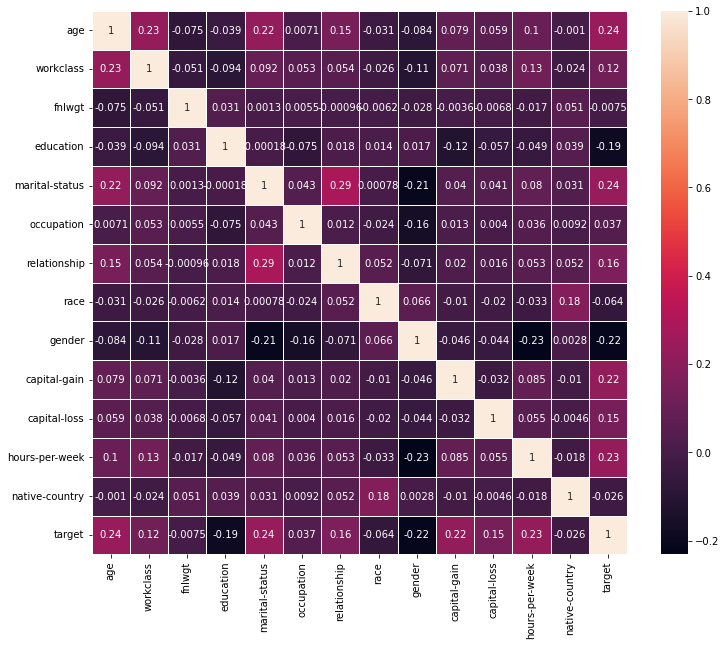

In [25]:
correlacio = train_m.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(correlacio, annot=True, linewidths=0.5)

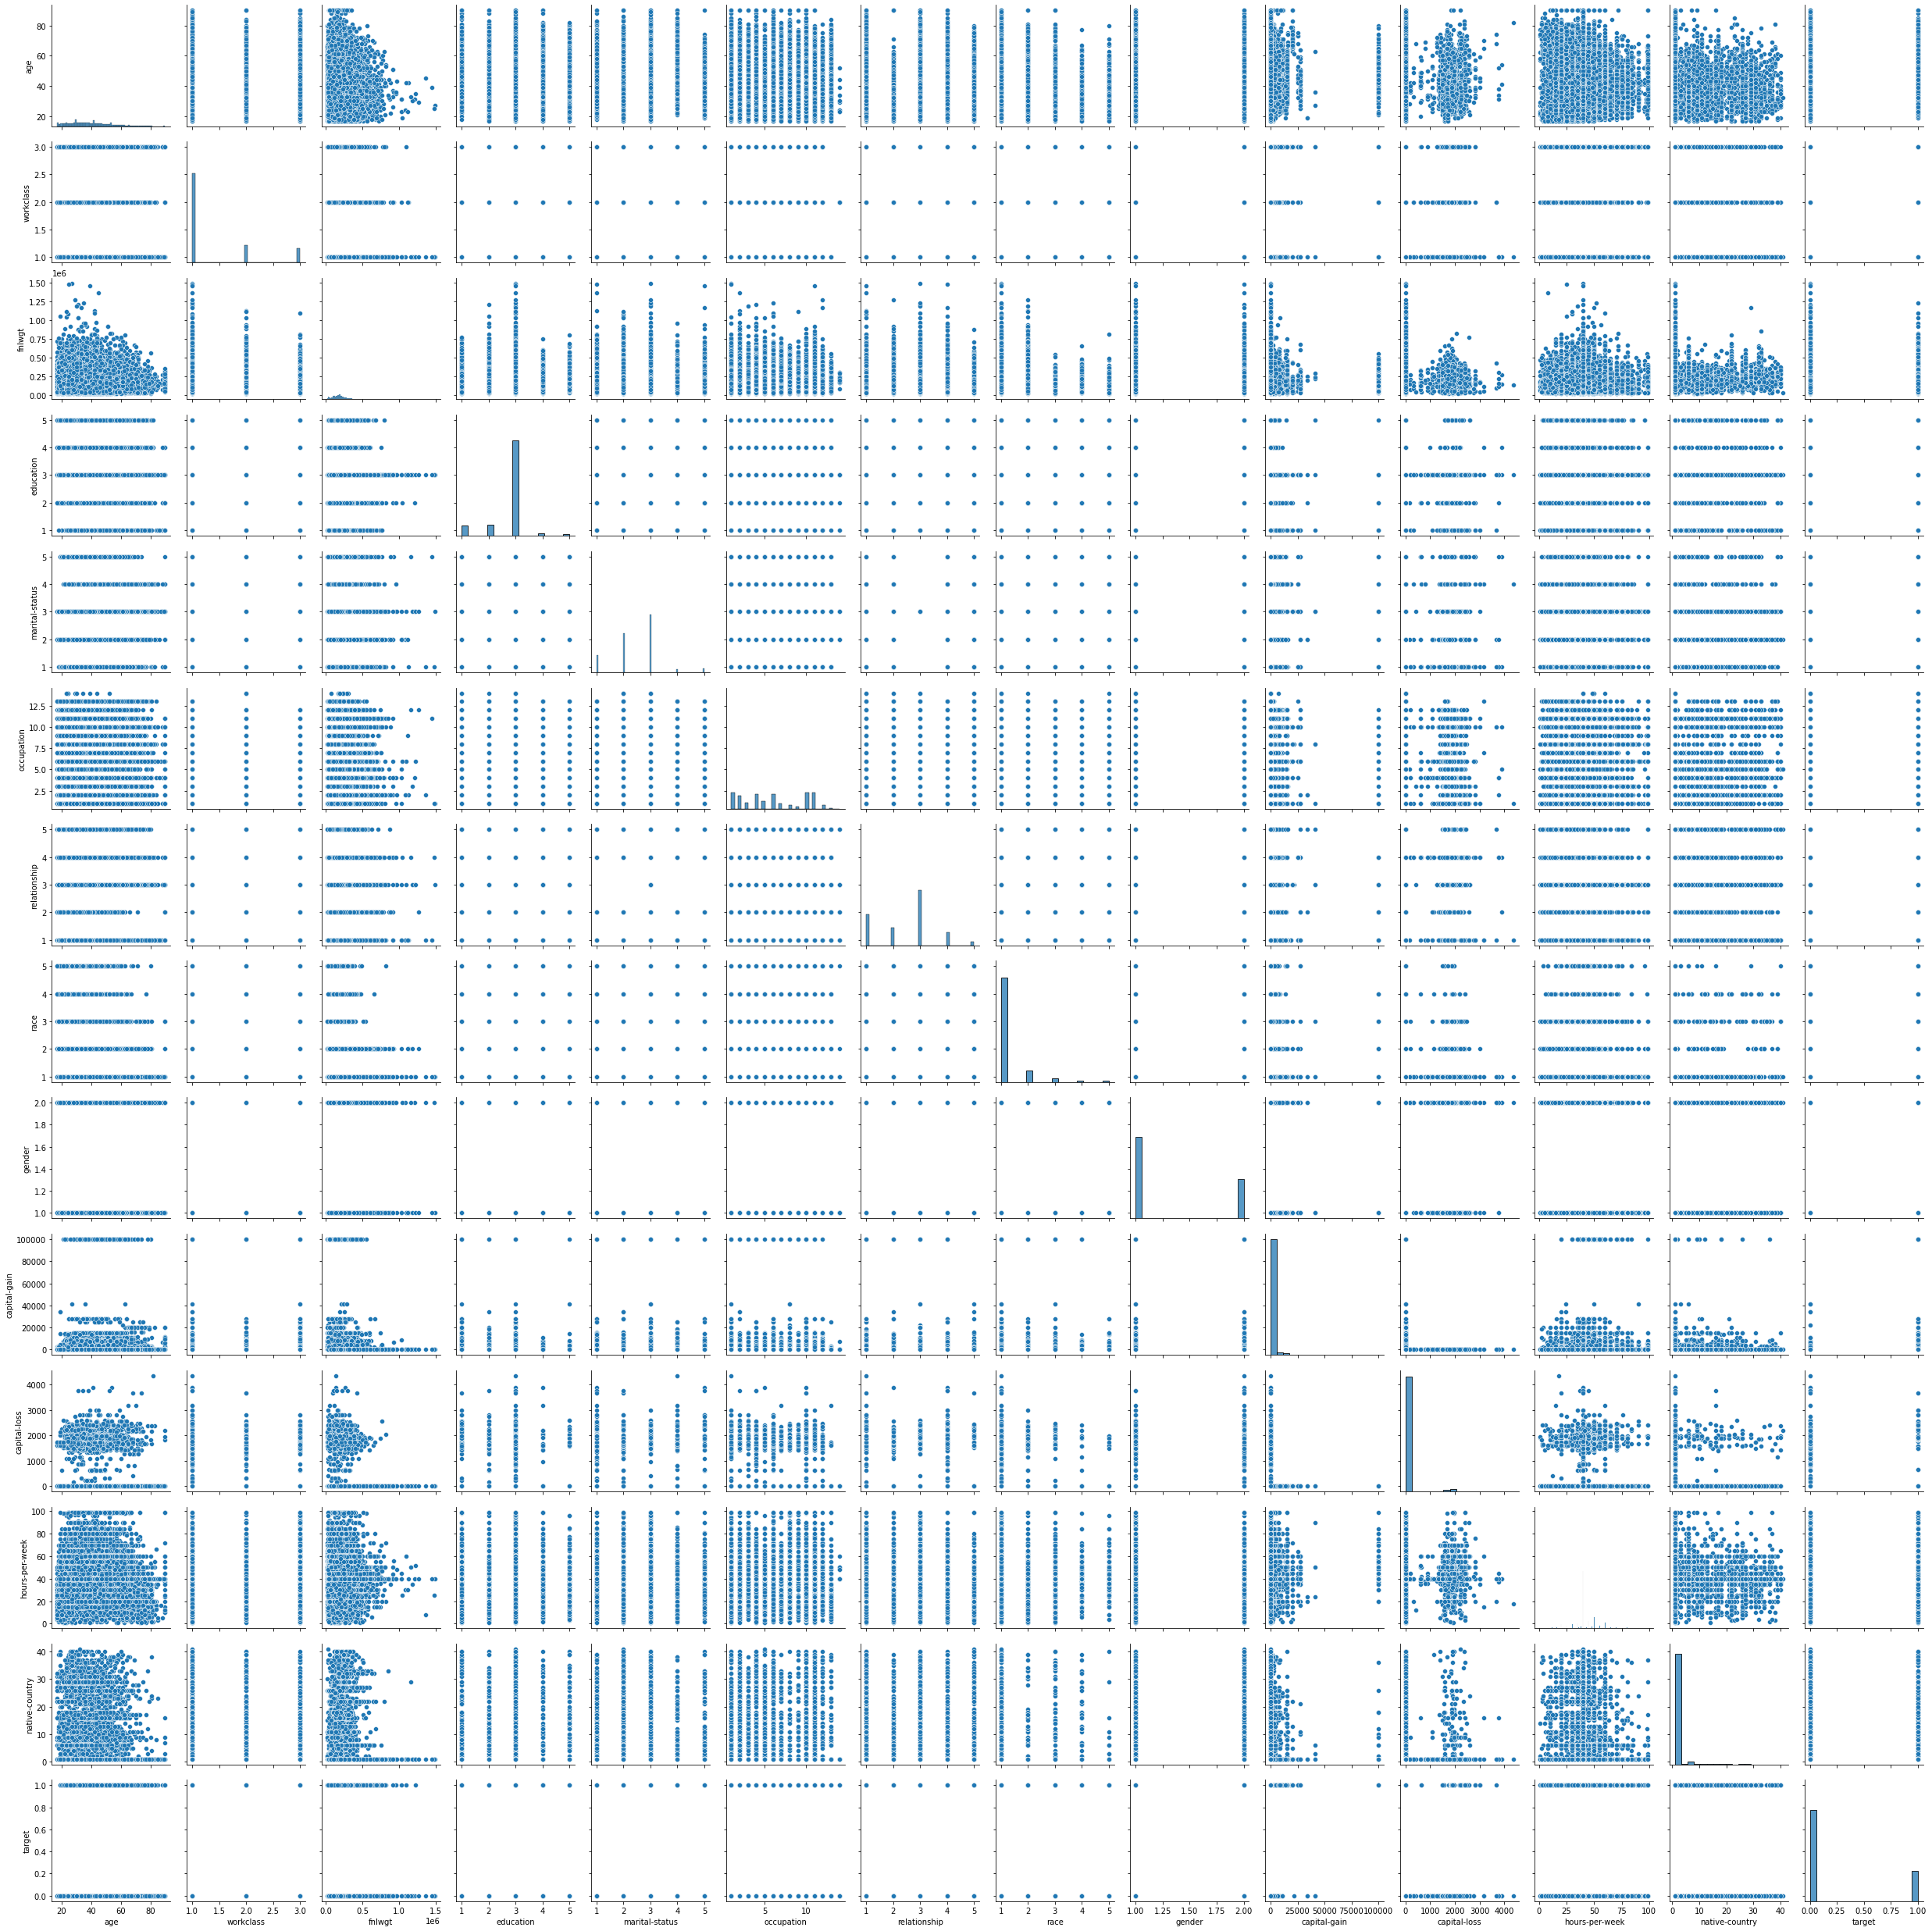

In [26]:
relacio = sns.pairplot(train_m)

In [27]:
train_m2 = train_m.copy()

train_m2 = train_m2[train_m2['race'] == 1]
train_m2 = train_m2[train_m2['native-country'] == 1]

train_m2.drop(columns = {'gender', 'education', 'fnlwgt', 'race', 'native-country'}, inplace = True)

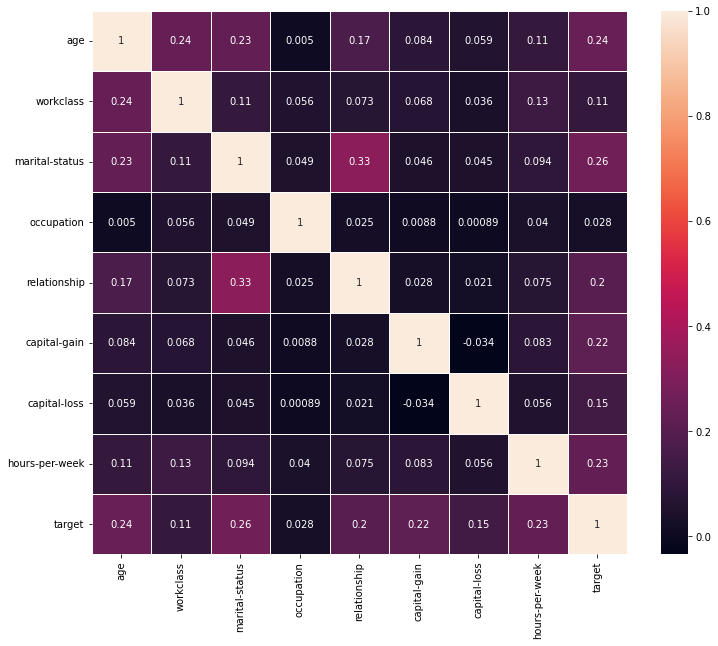

In [28]:
correlacio = train_m2.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(correlacio, annot=True, linewidths=0.5)

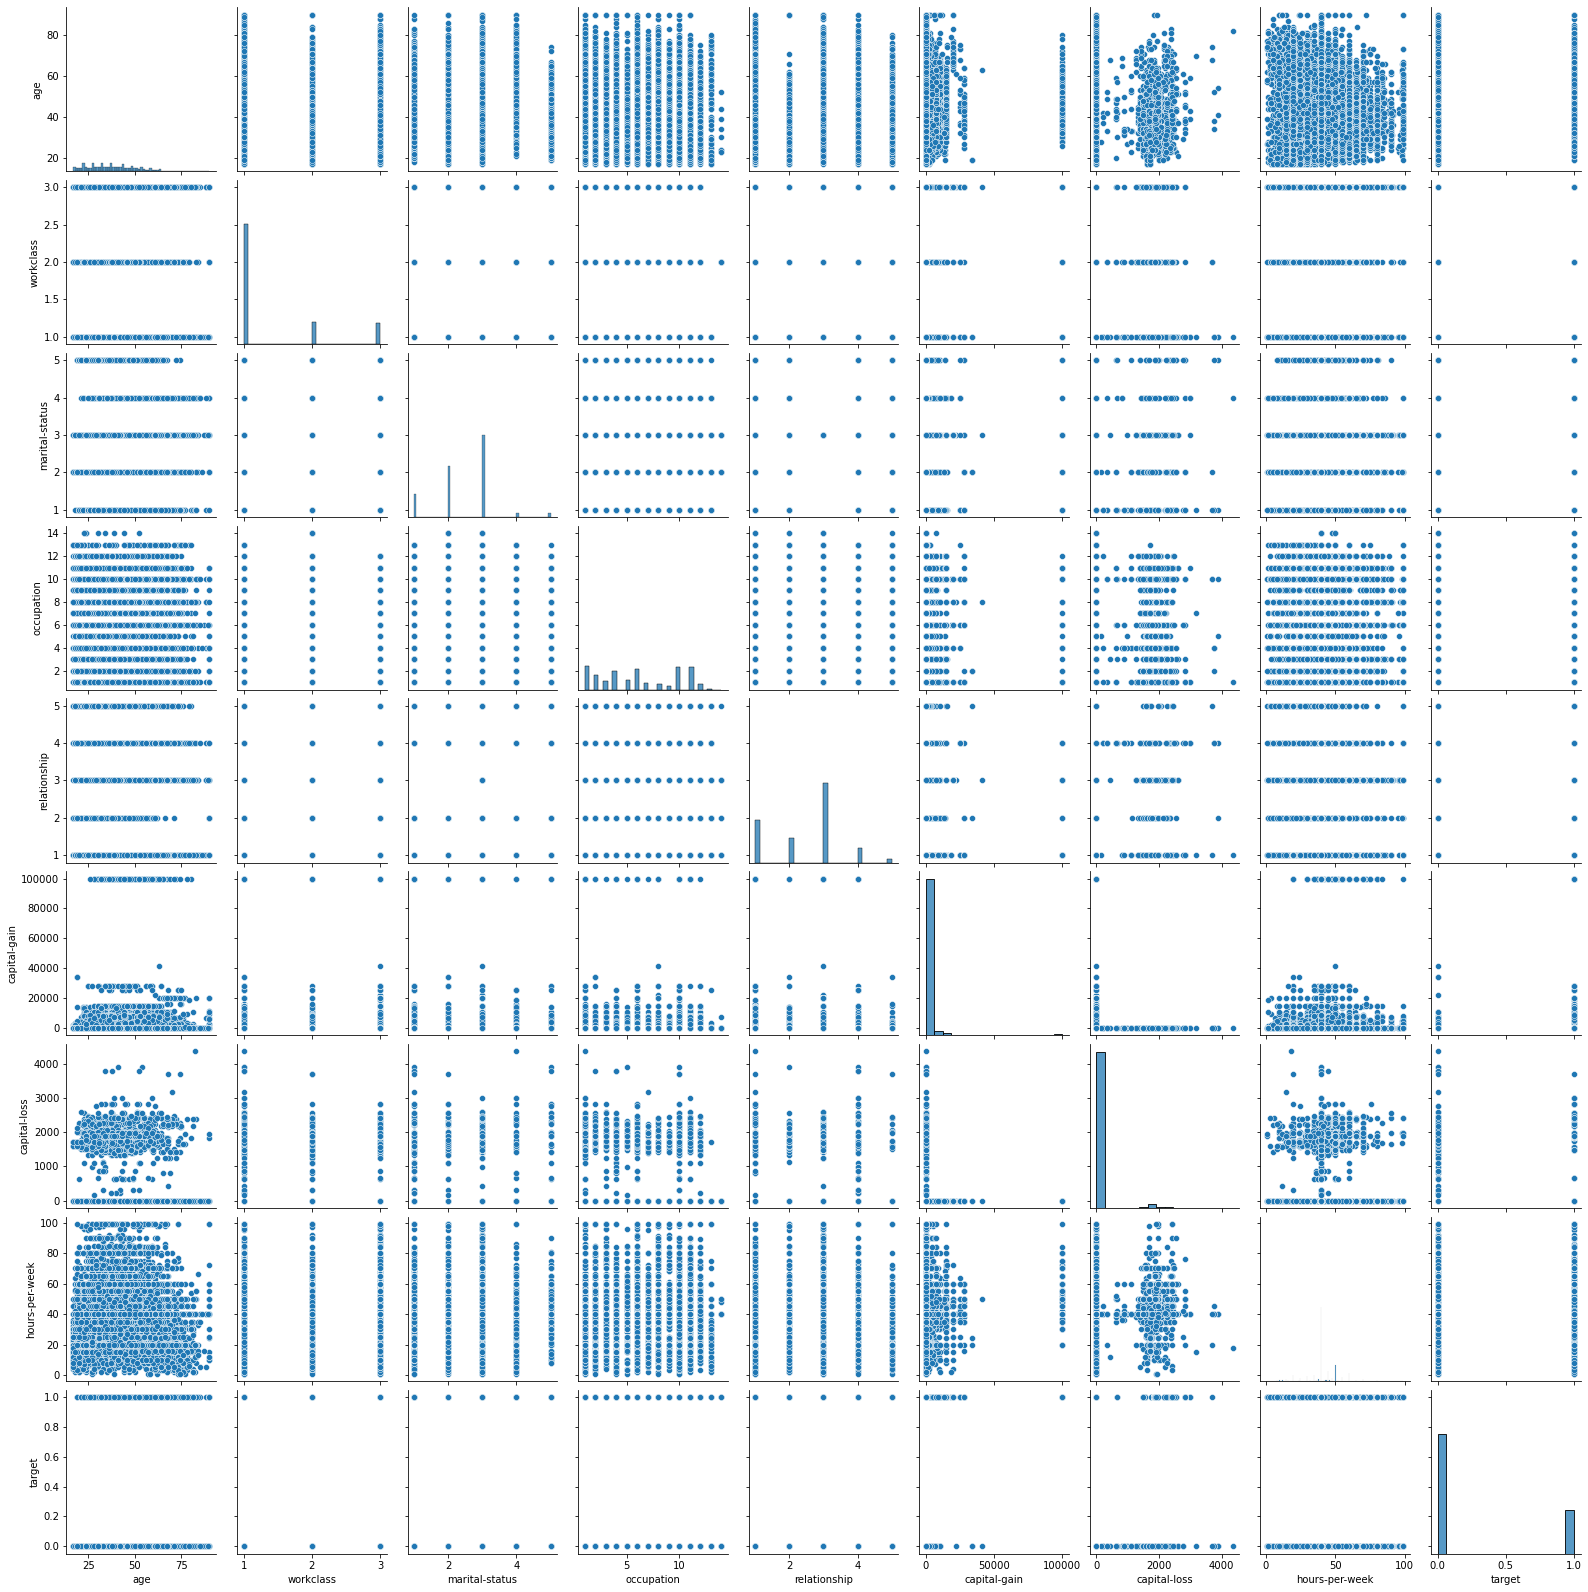

In [29]:
relacio = sns.pairplot(train_m2)

In [30]:
X = train_m.values[: , :-1]
Y = train_m.values[: , -1]

X_2 = train_m2.values[: , :-1]
Y_2 = train_m2.values[: , -1]

In [31]:
print(collections.Counter(Y))

Counter({0: 30617, 1: 10090})


In [32]:
sc = StandardScaler()
X_n = sc.fit_transform(X)
X_n2 = sc.fit_transform(X_2)

## Aplicació dels models

In [33]:
sizes = [0.25, 0.50, 0.75]
for size in sizes:
    x_train, x_test, y_train, y_test = train_test_split(X_n, Y, test_size = size, random_state = 0)
    
    #SVM
    svc = SVC(kernel = 'poly', probability=True)
    svc.fit(x_train, y_train)

    print("Score test - SVM with               ", size, "% of the data:" + str(svc.score(x_test, y_test)))
    print("Score train - SVM with              ", size, "% of the data:" + str(svc.score(x_train, y_train)))
    
    #Logistic Regressor
    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)

    print("Score test - Logistic with          ", size, "% of the data:" + str(logreg.score(x_test, y_test)))
    print("Score train - Logistic  with        ", size, "% of the data:" + str(logreg.score(x_train, y_train)))
    
    #KNeighbors
    knn = KNeighborsClassifier(algorithm = 'auto', n_jobs = -1)
    knn.fit(x_train, y_train)

    print("Score test - KNN with               ", size, "% of the data:" + str(knn.score(x_test, y_test)))
    print("Score train - KNN with              ", size, "% of the data:" + str(knn.score(x_train, y_train)))
    
    #Decision Tree
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)

    print("Score test - Decision Tree with     ", size, "% of the data:" + str(clf.score(x_test, y_test)))
    print("Score train - Decision Tree with    ", size, "% of the data:" + str(clf.score(x_train, y_train)))

Score test - SVM with                0.25 % of the data:0.8188071140807703
Score train - SVM with               0.25 % of the data:0.82368162463151
Score test - Logistic with           0.25 % of the data:0.807998427827454
Score train - Logistic  with         0.25 % of the data:0.8072387815263675
Score test - KNN with                0.25 % of the data:0.816448855261865
Score train - KNN with               0.25 % of the data:0.8700622338683263
Score test - Decision Tree with      0.25 % of the data:0.8089810356686646
Score train - Decision Tree with     0.25 % of the data:0.9998689813298395
Score test - SVM with                0.5 % of the data:0.8152205954603517
Score train - SVM with               0.5 % of the data:0.8238588905812411
Score test - Logistic with           0.5 % of the data:0.8073597327306672
Score train - Logistic  with         0.5 % of the data:0.8074976661917163
Score test - KNN with                0.5 % of the data:0.815711899380957
Score train - KNN with             

In [34]:
sizes = [0.25, 0.50, 0.75]
for size in sizes:
    x_train, x_test, y_train, y_test = train_test_split(X_n2, Y_2, test_size = size, random_state = 0)
    
    #SVM
    svc = SVC(kernel = 'poly', probability=True)
    svc.fit(x_train, y_train)

    print("Score test - SVM with               ", size, "% of the data:" + str(svc.score(x_test, y_test)))
    print("Score train - SVM with              ", size, "% of the data:" + str(svc.score(x_train, y_train)))
    
    #Logistic Regressor
    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)

    print("Score test - Logistic with          ", size, "% of the data:" + str(logreg.score(x_test, y_test)))
    print("Score train - Logistic  with        ", size, "% of the data:" + str(logreg.score(x_train, y_train)))
    
    #KNeighbors
    knn = KNeighborsClassifier(algorithm = 'auto', n_jobs = -1)
    knn.fit(x_train, y_train)

    print("Score test - KNN with               ", size, "% of the data:" + str(knn.score(x_test, y_test)))
    print("Score train - KNN with              ", size, "% of the data:" + str(knn.score(x_train, y_train)))
    
    #Decision Tree
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)

    print("Score test - Decision Tree with     ", size, "% of the data:" + str(clf.score(x_test, y_test)))
    print("Score train - Decision Tree with    ", size, "% of the data:" + str(clf.score(x_train, y_train)))

Score test - SVM with                0.25 % of the data:0.7964005876591577
Score train - SVM with               0.25 % of the data:0.7941152464903689
Score test - Logistic with           0.25 % of the data:0.7732615083251714
Score train - Logistic  with         0.25 % of the data:0.770241593209272
Score test - KNN with                0.25 % of the data:0.8143976493633692
Score train - KNN with               0.25 % of the data:0.8569213189683317
Score test - Decision Tree with      0.25 % of the data:0.8061949069539667
Score train - Decision Tree with     0.25 % of the data:0.9276036565458701
Score test - SVM with                0.5 % of the data:0.794013222331048
Score train - SVM with               0.5 % of the data:0.7926665034280117
Score test - Logistic with           0.5 % of the data:0.7700783545543585
Score train - Logistic  with         0.5 % of the data:0.7707517140058766
Score test - KNN with                0.5 % of the data:0.8056439764936337
Score train - KNN with          

Accuracy:0.8188071140807703
Precision:0.7954345917471466
Recall:0.3599523241954708


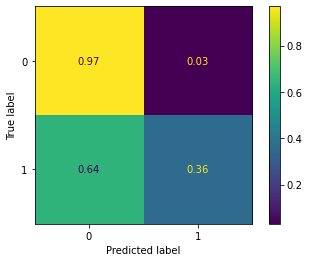

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X_n, Y, test_size = 0.25, random_state = 0)

svc = SVC(kernel = 'poly', probability=True)
svc.fit(x_train, y_train)

y_predictions = svc.predict(x_test)

acc = accuracy_score(y_test, y_predictions)
prec = precision_score(y_test, y_predictions)
rec = recall_score(y_test, y_predictions)

print(f'Accuracy:{acc}')
print(f'Precision:{prec}')
print(f'Recall:{rec}')
plot_confusion_matrix(svc, x_test, y_test, normalize='true')

Accuracy:0.8082932101798173
Precision:0.7202020202020202
Recall:0.37541134658417796


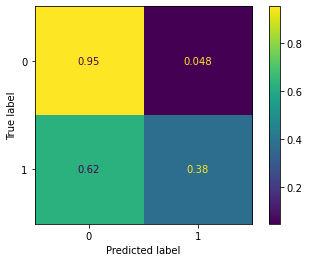

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X_n, Y, test_size = 0.75, random_state = 0)

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_predictions = logreg.predict(x_test)

acc = accuracy_score(y_test, y_predictions)
prec = precision_score(y_test, y_predictions)
rec = recall_score(y_test, y_predictions)

print(f'Accuracy:{acc}')
print(f'Precision:{prec}')
print(f'Recall:{rec}')
plot_confusion_matrix(logreg, x_test, y_test, normalize='true')

Accuracy:0.816448855261865
Precision:0.649746192893401
Recall:0.5593961064759635


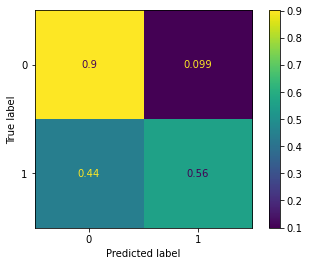

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X_n, Y, test_size = 0.25, random_state = 0)

knn = KNeighborsClassifier(algorithm = 'auto', n_jobs = -1)
knn.fit(x_train, y_train)

y_predictions = knn.predict(x_test)

acc = accuracy_score(y_test, y_predictions)
prec = precision_score(y_test, y_predictions)
rec = recall_score(y_test, y_predictions)

print(f'Accuracy:{acc}')
print(f'Precision:{prec}')
print(f'Recall:{rec}')
plot_confusion_matrix(knn, x_test, y_test, normalize='true')

Accuracy:0.8103566866463594
Precision:0.6186817630408411
Recall:0.6078665077473182


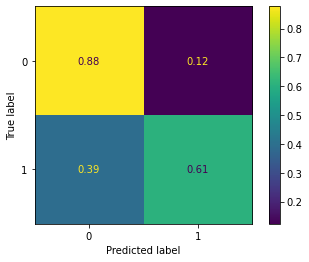

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X_n, Y, test_size = 0.25, random_state = 0)

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

y_predictions = clf.predict(x_test)

acc = accuracy_score(y_test, y_predictions)
prec = precision_score(y_test, y_predictions)
rec = recall_score(y_test, y_predictions)

print(f'Accuracy:{acc}')
print(f'Precision:{prec}')
print(f'Recall:{rec}')
plot_confusion_matrix(clf, x_test, y_test, normalize='true')